In [1]:
# %load_ext autoreload
# %autoreload 2

import os, json
import nibabel as nb

from keras import metrics 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LocallyConnected1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.utils.vis_utils import plot_model

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hrf_estimation
import scipy.signal as signal
import scipy.stats as stats

from joblib import Parallel, delayed

%matplotlib inline

Using TensorFlow backend.
/home/knapen/software/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/home/knapen/software/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [2]:
# requires pfpy be installed - preferably with python setup.py develop
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter

In [30]:
stim_dm = np.load('../data/dm.npy').T # transpose for final dimension time
prf_stim = PRFStimulus2D(screen_size_cm=70, 
                         screen_distance_cm=125, 
                         design_matrix=stim_dm, 
                         TR=1.6)

grid_nr = 20
max_ecc_size = 16
sizes, eccs, polars = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)

gg = Iso2DGaussianGridder(stimulus=prf_stim)
# gf = Iso2DGaussianFitter(data=, gridder=gg, n_jobs=-1, fit_css=True)

In [ ]:
mask = nb.load('../data/sub-01_task-prf_dir-AP_cortical_mask.nii.gz').get_data().astype(bool)
timecoursefile = nb.load('../data/sub-01_task-prf_acq-median_masked_T1w_desc-preproc_bold.nii.gz')
timecourse = timecoursefile.get_data()

In [ ]:
%%time
gf = Iso2DGaussianFitter(data=timecourse[mask], gridder=gg, n_jobs=8, fit_css=True)
gf.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes,
                 n_grid=np.linspace(0.2,1,4))


  0%|          | 0/32000 [00:00<?, ?it/s]/home/knapen/projects/prfpy/prfpy/fit.py:144: RuntimeWarning: divide by zero encountered in true_divide
  rsqs = ((1 - residual / (self.n_timepoints * self.data_var)))
/home/knapen/projects/prfpy/prfpy/fit.py:144: RuntimeWarning: invalid value encountered in true_divide
  rsqs = ((1 - residual / (self.n_timepoints * self.data_var)))
/home/knapen/projects/prfpy/prfpy/fit.py:146: RuntimeWarning: invalid value encountered in greater
  improved_fits = rsqs > self.gridsearch_r2

  2%|▏         | 498/32000 [02:37<2:46:17,  3.16it/s]

In [39]:
%%time
gf.iterative_fit(rsq_threshold=0.7, verbose=True)

CPU times: user 5min 43s, sys: 32.4 s, total: 6min 16s
Wall time: 6min 19s


In [37]:
gf.iterative_search_params.shape

(97069, 7)

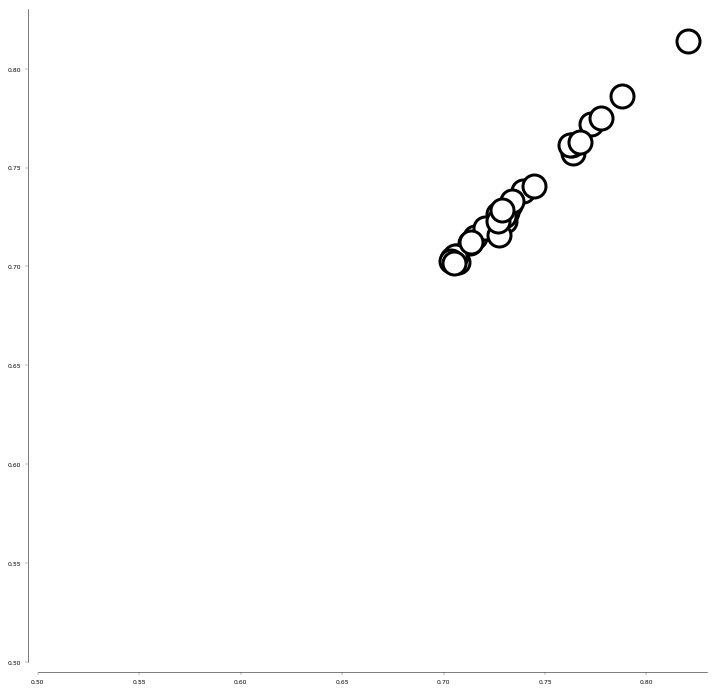

In [40]:
plt.figure(figsize=(12,12))
plt.plot(gf.iterative_search_params[gf.rsq_mask][:,-1], 
         gf.gridsearch_params[gf.rsq_mask][:,-1], 'wo', ms=23, mew=3, mec='k')
plt.gca().set_xlim([0.5,0.83])
plt.gca().set_ylim([0.5,0.83])
sns.despine(offset=10)


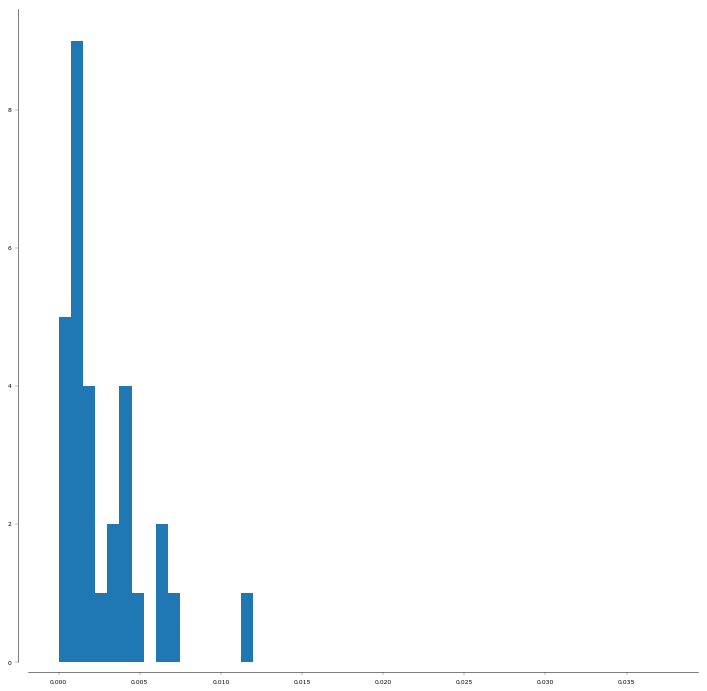

In [42]:
plt.figure(figsize=(12,12))
plt.hist(gf.iterative_search_params[gf.rsq_mask][:,-1] - gf.gridsearch_params[gf.rsq_mask][:,-1], bins=50, range=[0,0.0375])
# plt.gca().set_xlim([0.5,0.83])
# plt.gca().set_ylim([0.5,0.83])
sns.despine(offset=10)

